*Project in Principles of Security:*
***Analysis of attacks on RSA***

`Ilya Borovik, BS4-DS`

In [ ]:
from Crypto.PublicKey import RSA 

from fermat import fermat, fermat_sieve
from mathtools import closest_prime, n_common_digits
from gmpy2 import isqrt
from random import randint, seed
seed(23)

import matplotlib.pyplot as plt
import numpy as np
plt.style.use('default')

DATA_DIR = 'results/'

from time import time
def time_to_str(time):
    return f'{int(time/60.)}:{(time%60.):.7f}'

## Key generation

Function for key generation

In [4]:
def generate_key(bits=1024, e=65535,
                 p=None, q=None,
                 path='keys/key'):
    if p is None and q is None:
        key = RSA.generate(bits, e=e)
        pub_key = key.publickey().exportKey("PEM")
        priv_key = key.exportKey("PEM")

        if path is not None:
            with open(path + '.pub', 'wb') as f:
                f.write(pub_key)

            with open(path + '.priv', 'wb') as f:
                f.write(priv_key)

        return key

# Fermat Factorization

In [52]:
def test_fermat(p, file='fermat_test.txt'):
    print(f'Testing prime {p}')
    print(f'Safe diff order: {len(str(isqrt(p))) - 1}')

    with open(file, 'a') as f:
        f.write(f'{p}\n')

        for i in range(1, len(str(p))):
            q = p + 10 ** i + randint(0, 10 ** i)
            for _ in range(1):
                q = closest_prime(q)
            diff = q - p

            print('=' * 60)
            print(f' i={i}\n'
                  f'  common digits = {n_common_digits(p, q)},'
                  f' diff order = {len(str(diff)) - 1}\n'
                  f'  diff = {diff}')

            f.write(f'{i}\t{n_common_digits(p, q)}\t{len(str(diff)) - 1}\n{diff}\n')

            st = time()
            _, _, n_iter = fermat(p * q, count_iter=True)
            exec_time = time() - st
            print(f'Fermat\n  n_iter = {n_iter}, execution time = {time_to_str(time() - st)}')
            f.write(f'{n_iter}\t{exec_time:.7f}\t')
            
            st = time()
            _, _, n_iter = fermat_sieve(p * q, modulus=10, count_iter=True)
            exec_time = time() - st
            print(f'Fermat-Sieve (mod 10)\n  n_iter = {n_iter}, execution time = {time_to_str(time() - st)}')
            f.write(f'{n_iter}\t{exec_time:.7f}\t')
            
            st = time()
            _, _, n_iter = fermat_sieve(p * q, modulus=16, count_iter=True)
            exec_time = time() - st
            print(f'Fermat-Sieve (mod 16)\n  n_iter = {n_iter}, execution time = {time_to_str(time() - st)}')
            f.write(f'{n_iter}\t{exec_time:.7f}\n')

            if exec_time > 0.1:
                break

    print('=' * 60, '\n\n')

## Fermat with Sieve

In [41]:
from collections import defaultdict

def fermat_sieve(n, modulus=10, count_iter=False):
    # computing possible values of a  modulus arithmetic
    squares = defaultdict(list)
    for i in range(modulus):
        squares[i*i % modulus].append(i)

    mod_n = n % modulus
    modulus_a = []
    for s in squares:
        if (s + mod_n) % modulus in squares:
            modulus_a += squares[(s + mod_n) % modulus]
    modulus_a = set(modulus_a)

    root = isqrt(n)
    a, b = root, root
    b2 = a * a - n

    n_iter = 0
    while b * b != b2:
        a += 1
        while a % modulus not in modulus_a:
            a += 1

        b2 = a * a - n
        b = isqrt(b2)
        n_iter += 1

    p, q = a + b, a - b
    assert n == p * q

    if count_iter:
        return p, q, n_iter
    return p, q

### Square roots in Modulus arithmetics

In [47]:
for modulus in range(40):
    squares = defaultdict(list)
    for i in range(modulus):
        squares[i*i % modulus].append(i)
    print(modulus, dict(squares))

0 {}
1 {0: [0]}
2 {0: [0], 1: [1]}
3 {0: [0], 1: [1, 2]}
4 {0: [0, 2], 1: [1, 3]}
5 {0: [0], 1: [1, 4], 4: [2, 3]}
6 {0: [0], 1: [1, 5], 4: [2, 4], 3: [3]}
7 {0: [0], 1: [1, 6], 4: [2, 5], 2: [3, 4]}
8 {0: [0, 4], 1: [1, 3, 5, 7], 4: [2, 6]}
9 {0: [0, 3, 6], 1: [1, 8], 4: [2, 7], 7: [4, 5]}
10 {0: [0], 1: [1, 9], 4: [2, 8], 9: [3, 7], 6: [4, 6], 5: [5]}
11 {0: [0], 1: [1, 10], 4: [2, 9], 9: [3, 8], 5: [4, 7], 3: [5, 6]}
12 {0: [0, 6], 1: [1, 5, 7, 11], 4: [2, 4, 8, 10], 9: [3, 9]}
13 {0: [0], 1: [1, 12], 4: [2, 11], 9: [3, 10], 3: [4, 9], 12: [5, 8], 10: [6, 7]}
14 {0: [0], 1: [1, 13], 4: [2, 12], 9: [3, 11], 2: [4, 10], 11: [5, 9], 8: [6, 8], 7: [7]}
15 {0: [0], 1: [1, 4, 11, 14], 4: [2, 7, 8, 13], 9: [3, 12], 10: [5, 10], 6: [6, 9]}
16 {0: [0, 4, 8, 12], 1: [1, 7, 9, 15], 4: [2, 6, 10, 14], 9: [3, 5, 11, 13]}
17 {0: [0], 1: [1, 16], 4: [2, 15], 9: [3, 14], 16: [4, 13], 8: [5, 12], 2: [6, 11], 15: [7, 10], 13: [8, 9]}
18 {0: [0, 6, 12], 1: [1, 17], 4: [2, 16], 9: [3, 9, 15], 16: [4, 1

## Fermat analysis

In [313]:
from collections import defaultdict
bits_map = {1024: 82, 1536: 120, 2048: 159}

def parse_fermat_logs(bits):
    with open(DATA_DIR + f'fermat_test_{bits}.txt', 'r') as f:
        dos = []
        steps, times = defaultdict(list), defaultdict(list)
        for _ in range(5):
            dos_i = []
            f_ss_i, fs10_ss_i, fs16_ss_i = [], [], []
            f_ts_i, fs10_ts_i, fs16_ts_i = [], [], []
            p = int(f.readline().strip())
            for i in range(1, bits_map[bits]+1):
                cd, do = map(int, f.readline().strip().split('\t')[1:])
                dos_i.append(do)
                diff = int(f.readline().strip())
    
                res = f.readline().strip().split('\t')
                f_s, f_t, fs10_s, fs10_t, fs16_s, fs16_t = res
            
                f_ss_i.append(int(f_s))
                f_ts_i.append(float(f_t))
                fs10_ss_i.append(int(fs10_s))
                fs10_ts_i.append(float(fs10_t))
                fs16_ss_i.append(int(fs16_s))
                fs16_ts_i.append(float(fs16_t))
            
            dos.append(dos_i)
            steps['Fermat'].append(f_ss_i)
            times['Fermat'].append(f_ts_i)
            steps['Fermat-Sieve (mod 10)'].append(fs10_ss_i)
            times['Fermat-Sieve (mod 10)'].append(fs10_ts_i)
            steps['Fermat-Sieve (mod 16)'].append(fs16_ss_i)
            times['Fermat-Sieve (mod 16)'].append(fs16_ts_i)
            
    return dos, steps, times

In [325]:
def plot_stats(bits=1024, n_last=8):
    dos, steps, times = parse_fermat_logs(bits)
    
    x = np.arange(1, len(dos[0])+1)[-n_last:]
    
    fig, ax1 = plt.subplots(figsize=(8, 5))
    
    color = 'tab:red'
    ax1.set_title(f'Fermat factorization of {bits} bit modulus with varying p and q')
    ax1.set_xlabel('order of p-q')
    ax1.set_ylabel('# operations (log scale)', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('factorization time (s)', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    for k in steps:
        data_steps = np.array(steps[k])
        data_times = np.array(times[k])
        
        y_steps = np.log10(data_steps.mean(axis=0)[-n_last:])
        y_times = data_times.mean(axis=0)[-n_last:]

        ax1.plot(x, y_steps, lw=1.5, alpha=0.9)
        ax2.plot(x, y_times, alpha=0.25)
        
    ax1.legend(steps.keys())

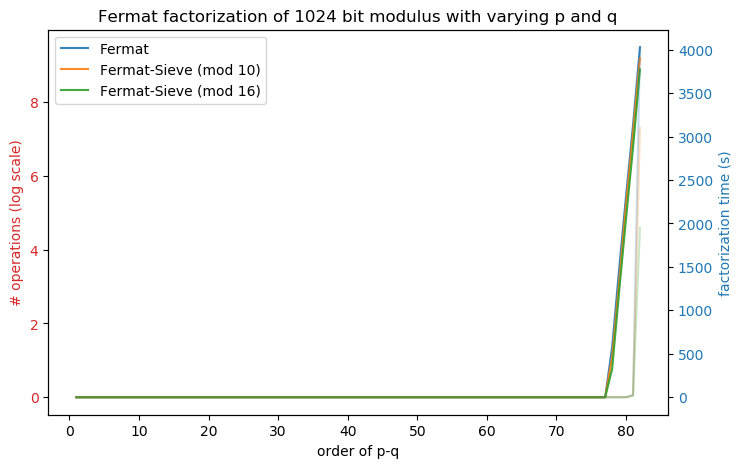

In [326]:
plot_stats(bits=1024, n_last=82)

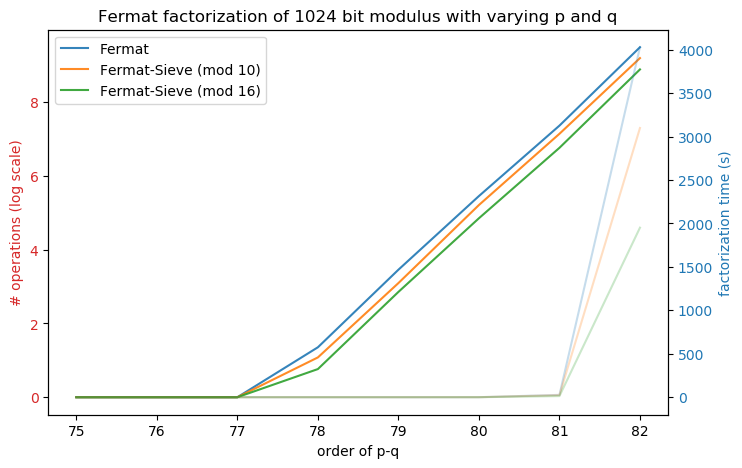

In [327]:
plot_stats(bits=1024)

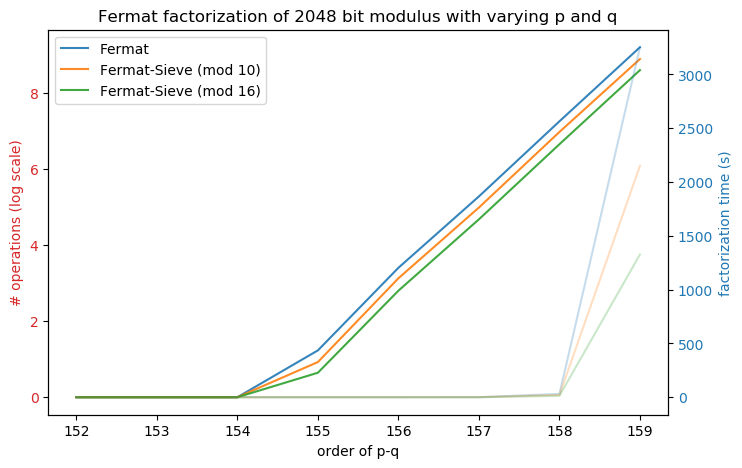

In [328]:
plot_stats(bits=2048)

## Algorithm comparison

Relative comparison to orginal Fermat Factorization.

In [329]:
def plot_comparison(bits):
    means_steps, std_steps = defaultdict(list), defaultdict(list)
    means_times, std_times = defaultdict(list), defaultdict(list)
    
    for b in bits:
        _, steps, times = parse_fermat_logs(b)
    
        data_steps = np.array(steps['Fermat'])
        mask = np.where(data_steps > 1)
        target_steps = np.array(steps['Fermat'])[mask]
        target_times = np.array(times['Fermat'])[mask]

        for k in steps.keys():
            data_steps = np.array(steps[k])[mask] / target_steps
            data_times = np.array(times[k])[mask] / target_times
            
            means_steps[k].append(data_steps.mean())
            std_steps[k].append(data_steps.std())
            means_times[k].append(data_times.mean())
            std_times[k].append(data_times.std())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    index = np.arange(len(bits))
    bar_width = 0.25

    opacity = 0.5
    error_config = {'ecolor': '0.3'}
    
    # steps
    keys = list(steps.keys())
    for i in range(len(keys)):
        k = keys[i]
        ax1.bar(index+bar_width*i, means_steps[k], bar_width,
               alpha=opacity,
               yerr=std_steps[k], error_kw=error_config,
               label=k)

    ax1.set_xlabel('key length in bits')
    ax1.set_ylabel('ratio of steps with respect to Fermat Factorization')
    ax1.set_title('Relative number of steps taken by algorithms')
    ax1.set_xticks(index + bar_width)
    ax1.set_xticklabels(bits)
    ax1.legend()
    
    # times
    keys = list(steps.keys())
    for i in range(len(keys)):
        k = keys[i]
        ax2.bar(index+bar_width*i, means_times[k], bar_width,
               alpha=opacity,
               yerr=std_times[k], error_kw=error_config,
               label=k)

    ax2.set_xlabel('key length in bits')
    ax2.set_ylabel('ratio of time with respect to Fermat Factorization time')
    ax2.set_title('Relative factorization time by algorithms')
    ax2.set_xticks(index + bar_width)
    ax2.set_xticklabels(bits)
    ax2.legend()

    fig.tight_layout()
    plt.show()
    
    return 

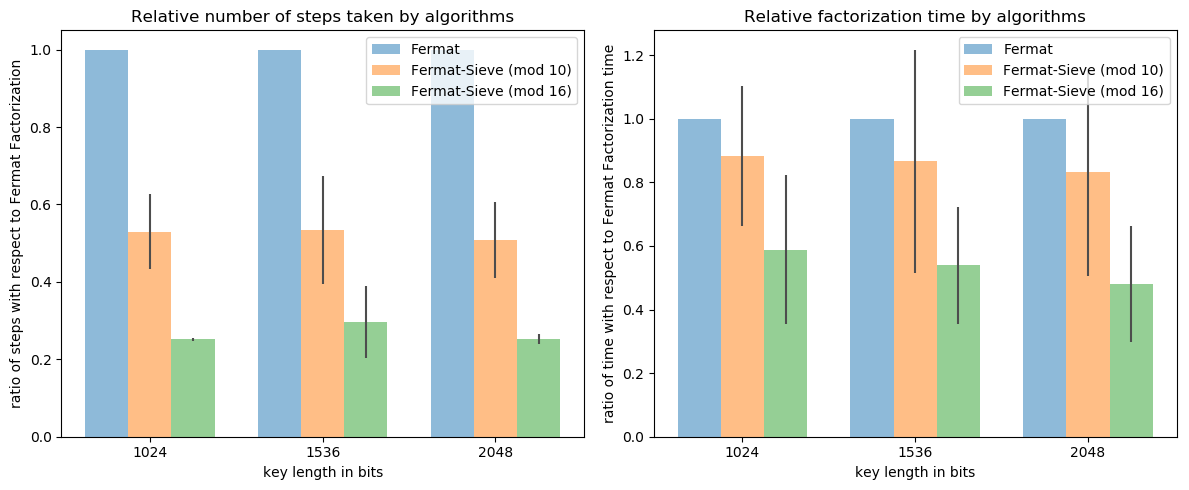

In [330]:
plot_comparison([1024, 1536, 2048])

## Key statistics

In [82]:
from collections import Counter

def collect_key_stats(bits, n_keys, file='key_stats.txt'):
    common_digits = Counter()
    diff_order = Counter()
    
    for i in range(n_keys):
        key = generate_key(bits=bits, path=None)
        p, q = key.p, key.q
        
        common_digits.update({n_common_digits(p, q): 1})
        
        diff = p - q if p > q else q - p
        diff_order.update({len(str(diff)) - 1: 1})
        
        if (i+1) % 10 == 0:
            with open(file, 'w') as f:
                f.write('common digits\n')
                for k, v in sorted(common_digits.items(), key=lambda x: x):
                    f.write(f'{k} {v}\n')
                f.write('diff order\n')
                for k, v in sorted(diff_order.items(), key=lambda x: x):
                    f.write(f'{k} {v}\n')
        
    return common_digits, diff_order

In [339]:
def read_key_stats(bits):
    common_digits = Counter()
    diff_order = Counter()

    with open(DATA_DIR + f'key_stats_{bits}.txt', 'r') as f:
        tokens = f.readline().strip().split()
        while tokens[0] != 'diff':
            tokens = f.readline().strip().split()
            if tokens[0] != 'diff':
                common_digits.update({int(tokens[0]): int(tokens[1])})

        while True:
            line = f.readline()
            if not line:
                break
            tokens = line.strip().split()
            diff_order.update({int(tokens[0]): int(tokens[1])})

    return common_digits, diff_order

In [416]:
from matplotlib.ticker import MultipleLocator

def plot_key_stats(bits):
    values = {}
    labels = {}
    min_x, max_x = 200, 0
    
    for b in bits:
        common_digits, diff_order = read_key_stats(b)
        
        lbl, val = zip(*common_digits.items())
        val = val / np.sum(val)
        min_x, max_x = min(min_x, min(lbl)), max(max_x, max(lbl))
            
        labels[b] = lbl
        values[b] = val

    indexes = np.arange(len(labels))
    width = 0.9        

    fig, ax1 = plt.subplots(figsize=(12, 5))

    bar_width = 0.25

    opacity = 0.5
    
    # steps
    for i in range(len(bits)):
        b = bits[i]
        indexes = np.array(labels[b])
        ax1.bar(indexes+bar_width*i, values[b], bar_width,
                alpha=opacity, label=b)

    ax1.set_title('Number of shared leading digits in p and q')
    ax1.set_xlabel('number of shared leading bits')
    ax1.set_ylabel('ratio of keys')
    
    ax1.set_xticks(np.arange(max_x-min_x+1) + bar_width)
    ax1.set_xticklabels(np.arange(min_x, max_x+1))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax1.yaxis.grid(which="minor", linestyle='--', linewidth=0.2)
    
    ax1.legend()
    
    fig.tight_layout()
    plt.show()
    
    return 

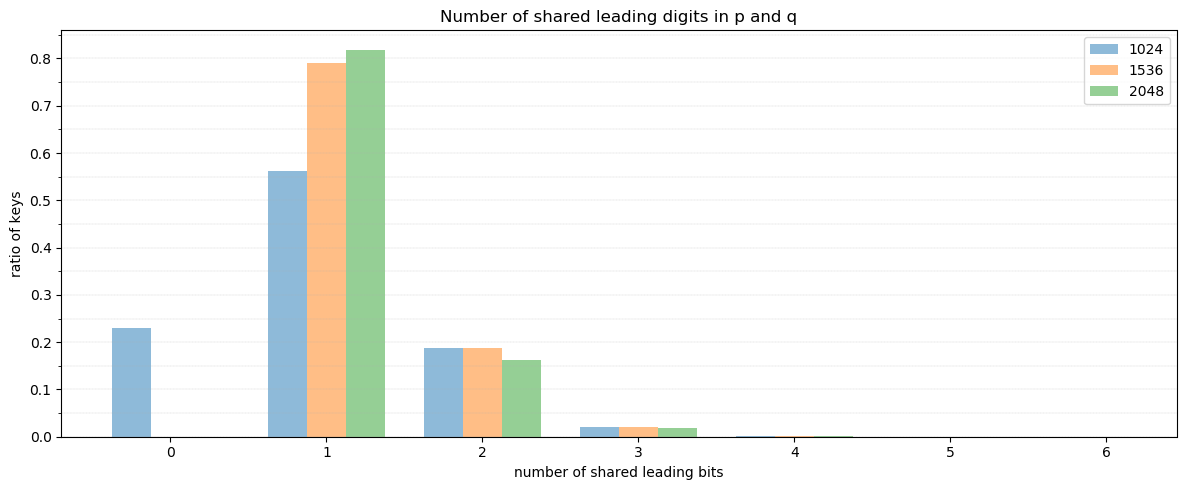

In [417]:
plot_key_stats([1024, 1536, 2048])

# Hastad's Broadcast attack

In [1]:
from hastads_test import test_hastads, hastads_experiment

In [3]:
message = 'Perseverance is paramount to success. ' \
          'Whatever your goal - do not give up and do not put up with mediocre!'

test_hastads(message, e=3, bits=1024)

test_hastads(message[:50], e=3, bits=1024, pad_cipher=True)

test_hastads(message, e=3, bits=1536)

test_hastads(message, e=3, bits=2048)

test_hastads(message, e=7, bits=1024)

test_hastads(message, e=7, bits=1024, n_keys=5)

test_hastads(message, e=17, bits=1024)

Testing Hastad's attack for e=3 and 1024 bit keys without padded encryption using 3 keys
Generating 3 keys
 Encrypted data with key 1
 Encrypted data with key 2
 Encrypted data with key 3
Running Hastad's Broadcast attack

Finished attack in 0.0019388 s
 Original message:   Perseverance is paramount to success. Whatever your goal - do not give up and do not put up with mediocre!
 Decrypted message:  Perseverance is paramount to success. Whatever your goal - do not give up and do not put up with mediocre!
 Attack succeeded!

Testing Hastad's attack for e=3 and 1024 bit keys with padded encryption using 3 keys
Generating 3 keys
 Encrypted data with key 1
 Encrypted data with key 2
 Encrypted data with key 3
Running Hastad's Broadcast attack

Finished attack in 0.0018899 s
 Original message:   Perseverance is paramount to success. Whatever you
 Decrypted message:  None
 Attack failed :(

Testing Hastad's attack for e=3 and 1536 bit keys without padded encryption using 3 keys
Generating 3 

'Perseverance is paramount to success. Whatever your goal - do not give up and do not put up with mediocre!'

### Less than 3 keys

In [5]:
e = 17 
for n_keys in range(1, e+1):
    test_hastads(message, e=e, bits=1024, n_keys=n_keys)

Testing Hastad's attack for e=17 and 1024 bit keys without padded encryption using 1 keys
Generating 1 keys
 Encrypted data with key 1
Running Hastad's Broadcast attack

Finished attack in 0.0001903 s
 Original message:   Perseverance is paramount to success. Whatever your goal - do not give up and do not put up with mediocre!
 Decrypted message:  None
 Attack failed :(

Testing Hastad's attack for e=17 and 1024 bit keys without padded encryption using 2 keys
Generating 2 keys
 Encrypted data with key 1
 Encrypted data with key 2
Running Hastad's Broadcast attack

Finished attack in 0.0012002 s
 Original message:   Perseverance is paramount to success. Whatever your goal - do not give up and do not put up with mediocre!
 Decrypted message:  None
 Attack failed :(

Testing Hastad's attack for e=17 and 1024 bit keys without padded encryption using 3 keys
Generating 3 keys
 Encrypted data with key 1
 Encrypted data with key 2
 Encrypted data with key 3
Running Hastad's Broadcast attack

F

 Encrypted data with key 15
Running Hastad's Broadcast attack

Finished attack in 0.0283711 s
 Original message:   Perseverance is paramount to success. Whatever your goal - do not give up and do not put up with mediocre!
 Decrypted message:  Perseverance is paramount to success. Whatever your goal - do not give up and do not put up with mediocre!
 Attack succeeded!

Testing Hastad's attack for e=17 and 1024 bit keys without padded encryption using 16 keys
Generating 16 keys
 Encrypted data with key 1
 Encrypted data with key 2
 Encrypted data with key 3
 Encrypted data with key 4
 Encrypted data with key 5
 Encrypted data with key 6
 Encrypted data with key 7
 Encrypted data with key 8
 Encrypted data with key 9
 Encrypted data with key 10
 Encrypted data with key 11
 Encrypted data with key 12
 Encrypted data with key 13
 Encrypted data with key 14
 Encrypted data with key 15
 Encrypted data with key 16
Running Hastad's Broadcast attack

Finished attack in 0.0262139 s
 Original messa

In [7]:
e_list = [2*i+1 for i in range(1, 49)]

e_success = hastads_experiment(message, e_list)

Testing e=3
 Succeeded with [3] keys
Testing e=5
 Succeeded with [5] keys
Testing e=7
 Succeeded with [6, 7] keys
Testing e=9
 Succeeded with [8, 9] keys
Testing e=11
 Succeeded with [10, 11] keys
Testing e=13
 Succeeded with [11, 12, 13] keys
Testing e=15
 Succeeded with [13, 14, 15] keys
Testing e=17
 Succeeded with [15, 16, 17] keys
Testing e=19
 Succeeded with [16, 17, 18, 19] keys
Testing e=21
 Succeeded with [18, 19, 20, 21] keys
Testing e=23
 Succeeded with [20, 21, 22, 23] keys
Testing e=25
 Succeeded with [21, 22, 23, 24, 25] keys
Testing e=27
 Succeeded with [23, 24, 25, 26, 27] keys
Testing e=29
 Succeeded with [24, 25, 26, 27, 28, 29] keys
Testing e=31
 Succeeded with [26, 27, 28, 29, 30, 31] keys
Testing e=33
 Succeeded with [28, 29, 30, 31, 32, 33] keys
Testing e=35
 Succeeded with [29, 30, 31, 32, 33, 34, 35] keys
Testing e=37
 Succeeded with [31, 32, 33, 34, 35, 36, 37] keys
Testing e=39
 Succeeded with [33, 34, 35, 36, 37, 38, 39] keys
Testing e=41
 Succeeded with [34,

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hastads_stats(data):
    x = np.array(list(data.keys()))
    y = np.array(list(map(lambda x: min(np.array(x[1])), data.items())))
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.set_title(f'Number of ciphertexts needed to decrypt data')
    ax.set_xlabel('public exponent e')
    ax.set_ylabel('number of ciphertexts')

    ax.plot(x, x, alpha=0.9)
    ax.plot(x, y, alpha=0.9)
        
    ax.legend(['e', 'min number of needed ciphertexts'])

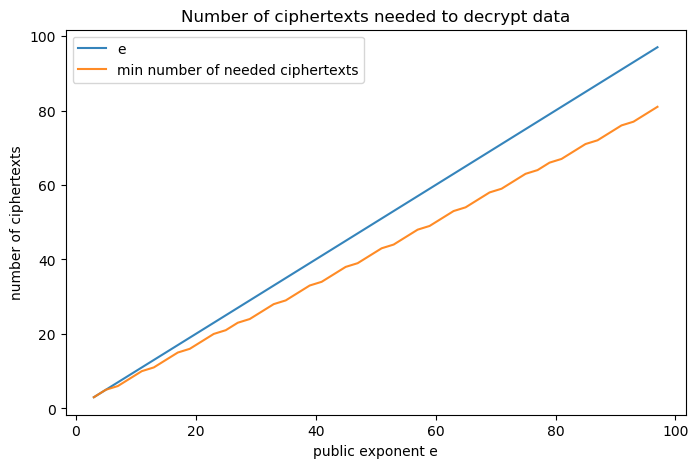

In [41]:
plot_hastads_stats(e_success)